# Matrix Factorization Recommendation Retrieval 

A typical recommender system has two phases: preference learning and recommendation retrieval. While the former can be done offline, the latter needs to be fast. However, the cost of linearly scanning through the whole set of billions of items are prohibitive or sometimes even impossible. 
In this tutorial, what are the key takeaways:
1. Recommendation retrieval is a similarity search problem (user is the query)
2. Exhaustive search over the whole item set is expensive (when the dimension increases or the number of items increases)

In this tutorial, we will investigate the complexity of linear scanning solution for MF-based recommendation retrieval. In particular, we train Probabilistic Matrix Factorization (PMF) model with Movielens 1M dataset.  

In [1]:
%matplotlib inline
import numpy as np
import time
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from utils.lsh import *
from utils.load_data import *
from utils.pmf import *

# Recommendation Retrieval is a Similarity Search Problem 

Two phases of a recommendation system:
1. **Learning phase:** derive a d-dimensional vector $x_u$ for each user $u$ and a d-dimensional vector $y_i$ for each item $i$. The user-item relationship is modelled using the inner product kernel, i.e., the user preference of user $u$ over an item $i$:

$$\mathbf{preference}(u, i) = x_u^Ty_i$$


2. **Retrieval phase:** given a user vector $x_u$, construct a recommendation list of $K$ items with highest preference score. This step requires $\mathcal{O}(n \times d)$ preference score computations and $\mathcal{O}(n \times \log(n))$. 

   The total cost of the retrieval step is:

$$\mathcal{O}(n \times d + n \times \log(n)) $$

We include below here the illustration of the two phases from the presentation:


<img src="resources/images/two_phases.png" width="500">

Next, we are going to take a closer look at the linear scanning solution. The matrix factorization model that we use for illustration purpose is Probabilistic Matrix Factorization (PMF).  

## Probabilistic Matrix Factorization

Probabilistic Matrix Factorization is introduced in the following paper: <a Mnih, A., & Salakhutdinov, R. R. (2008). Probabilistic matrix factorization. In Advances in neural information processing systems (pp. 1257-1264)>http://papers.nips.cc/paper/3208-probabilistic-matrix-factorization</a>. 

The objective is to learn for each user $u$ a vector $x_u$ and each item $i$ a vector $y_i$, such that the following error function is minimized:
\begin{equation}
 E = \sum_{u = 1}^{m}\sum_{i = 1}^{n}I_{ui}(r_{ui} - x_u^Ty_i)^2 + \lambda_x\sum_{u = 1}^{m}||x_u||^2 + \lambda_y\sum_{i = 1}^{n}||y_i||^2, 
\end{equation}
in which $I_{ui} = 1$ if $u$ rated $i$ in the training data and 0 otherwise. $\lambda_x$ and $\lambda_y$ are regularization terms for user vectors and item vectors respectively.

## Movielens 1M Dataset

This dataset contains 1 million ratings from 6000 users on 4000 movies. The dataset is contained in the 'data/ml-1m' folder.
Link to download the dataset: <a>https://grouplens.org/datasets/movielens/1m/</a>

In [2]:
import re

# load movielens data 
file_path = "data/ml-1m/ratings.dat"
prefer = []
for line in open(file_path, 'r'): 
    (userid, movieid, rating, ts) = re.split("\t|,|::", line) 
    uid = int(userid)
    mid = int(movieid)
    rat = float(rating)
    prefer.append([uid, mid, rat])

ratings = array(prefer)

In [3]:
# split data into train/test pair with 70/30 ratio.
train, test = train_test_split(ratings, test_size = 0.3)

### Train PMF algorithm with Movielens 20M dataset

#users: 6040 -- #items: 3706 -- #factors: 100
Epoch: 10-th: Training RMSE 1.086631, Test RMSE 1.105895
Epoch: 20-th: Training RMSE 0.956504, Test RMSE 0.992460
Epoch: 30-th: Training RMSE 0.885465, Test RMSE 0.933433
Epoch: 40-th: Training RMSE 0.851180, Test RMSE 0.910847
Epoch: 50-th: Training RMSE 0.825322, Test RMSE 0.897468
Epoch: 60-th: Training RMSE 0.802880, Test RMSE 0.887843
Epoch: 70-th: Training RMSE 0.782795, Test RMSE 0.881810
Epoch: 80-th: Training RMSE 0.763966, Test RMSE 0.876815
Epoch: 90-th: Training RMSE 0.746424, Test RMSE 0.873474
Epoch: 100-th: Training RMSE 0.730179, Test RMSE 0.871266
Epoch: 110-th: Training RMSE 0.715044, Test RMSE 0.869442
Epoch: 120-th: Training RMSE 0.701525, Test RMSE 0.868610
Epoch: 130-th: Training RMSE 0.688918, Test RMSE 0.868287
Epoch: 140-th: Training RMSE 0.677198, Test RMSE 0.867497
Epoch: 150-th: Training RMSE 0.666723, Test RMSE 0.867561
Done!


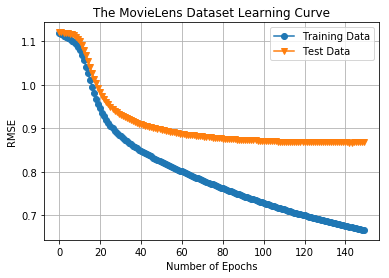

In [4]:
# learning from the training data
pmf = PMF()
pmf.set_params({"num_feat": 100, "epsilon": 1, "_lambda": 0.1, "maxepoch": 150, "num_batches": 100})
print("#users: {0} -- #items: {1} -- #factors: {2}".format(len(np.unique(ratings[:, 0])), len(np.unique(ratings[:, 1])), pmf.num_feat))

# training PMF with Movielens dataset
pmf.fit(train, test)

#Check performance by plotting train and test RMSE errors
plt.plot(range(pmf.maxepoch), pmf.rmse_train, marker='o', label='Training Data')
plt.plot(range(pmf.maxepoch), pmf.rmse_test, marker='v', label='Test Data')
plt.title('The MovieLens Dataset Learning Curve')
plt.xlabel('Number of Epochs')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

In [5]:
#save model, training/testing data for future use
model_output = "pmf_mvl1m.model"
pickle.dump(pmf, open(model_output, 'wb'))
pickle.dump(train, open('train_data', 'wb'))
pickle.dump(test, open('test_data', 'wb'))

### Complexity of Linear Scaning 


<img src="resources/images/retrieval_phase.png" width="700">

Given a user query vector $x_u$, the time complexity of linearly scanning through all items is $O(n * d)$, in which:
- $n$ is the number of items
- $d$ is the number of factors

## As the number of items increases

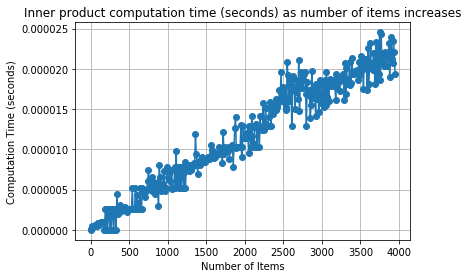

In [6]:
computation_time = []

data = pmf.w_Item
queries = pmf.w_User

#test queries
q = queries.T

for incr_size in range(0, data.shape[0], 10):
    start_time = time.time()
    pred = np.matmul(data[:incr_size, :], q)
    end_time   = time.time()
    computation_time.append((end_time - start_time)/q.shape[1])

#plot the computation time as the number of items increases
plt.plot(range(0, data.shape[0], 10), computation_time, marker='o', label='Computation_time')
plt.title('Inner product computation time (seconds) as number of items increases')
plt.xlabel('Number of Items')
plt.ylabel('Computation Time (seconds)')
plt.grid()
plt.show()

## As the number of features increases 

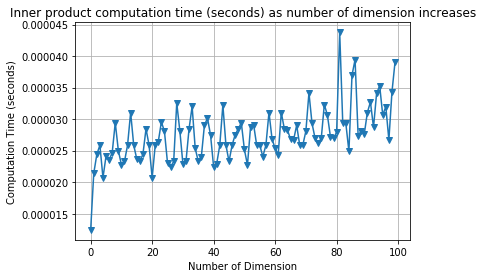

In [9]:
computation_time = []

for d in range(pmf.num_feat):
    start_time = time.time()
    pred = np.matmul(data[:incr_size, :d], q[:d, :])
    end_time   = time.time()
    computation_time.append((end_time - start_time)/q.shape[1])

#plot the computation time as the number of dimension increases
plt.plot(range(pmf.num_feat), computation_time, marker='v', label='Computation_time')
plt.title('Inner product computation time (seconds) as number of dimension increases')
plt.xlabel('Number of Dimension')
plt.ylabel('Computation Time (seconds)')
plt.grid()
plt.show()